In [174]:
import numpy as np
import cv2
import skimage
from skimage import io
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.morphology import reconstruction
from scipy import stats
from statistics import mean 
import imutils
from collections import OrderedDict
import plotly.graph_objects as go
import pandas as pd

#Optional modules
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform

In [175]:
img = cv2.imread('../example_images/sem_1.jpg',0)

In [176]:
def boundary_detection(img, thres = 20):
    '''
    thres: threshold to distinguish the scale bar background with particle background by grey scale
    for now only work for SEM img, needs update if apply to different imgs
    scan from upper to bottom, also needs update if need scan from left to right
    '''
    mode_list = []
    for line in range(len(img)):
        mode = stats.mode(img[line])
        mode_list.append(int(mode[0]))
        
        if line >= 1:
            mode_mean = mean(mode_list)
            if mode_mean - int(mode[0]) >= thres:
                boundary = line
                break
        
    return boundary

In [177]:
def dilated_image(img,sigma):
    '''filtering regional maxima to find bright features by using gaussian filter and reconstruction
    simga: standard deviation for Gaussian kernel '''
    # Convert to float: Important for subtraction later which won't work with uint8
    img = gaussian_filter(img, sigma)

    seed = np.copy(img)
    seed[1:-1, 1:-1] = img.min()
    mask = img

    dilated = reconstruction(seed, mask, method='dilation')
    return dilated


In [178]:
def corner_detection(img):
    """
    This function is used to find the length pixel of the scale bar.
    The imput should be just bottom part of the initial SEM image.
    This function uses the return result of boundary_detection.
    """
    height = img.shape[0]
    width = img.shape[1]
    #find the bottom part of the SEM image. Here we used the return refunction 
    ime = img[boundary_detection(dilated_image(img,1)): , int(width/2): ]
    
    tform = AffineTransform()
    image = warp(ime,tform.inverse)
    coords = corner_peaks(corner_harris(image))
    coords_subpix = corner_subpix(image, coords)
    
    scales = []
    threshold = 500
    for i in range(len(coords)):
        for j in range(len(coords)):
            if j <= i:
                continue
            else:
                if coords[i][0] == coords[j][0]:
                    scale = abs(coords[i][1] - coords[j][1])
                    if scale > threshold:
                        scales.append((coords[i][0],scale))
                    else:
                        continue
                else:
                    continue
    scalebar = []
    for i in range(len(scales)):
        n_count = 0
        for j in range(len(scales)):
            if scales[i][0] == scales[j][0]:
                n_count += 1
            else:
                continue
        if n_count == 1:
            scalebar.append((scales[i][0], scales[i][1]))
        else:
            continue
    #get the length of the scale bar
    #length_scale_bar = abs(coords[0][1] - coords[1][1])
    #plot
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(image, cmap=plt.cm.gray)
    ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
            linestyle='None', markersize=6)
    ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=10)
    plt.show()
    return scalebar

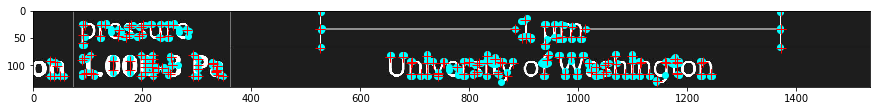

[(2, 844), (32, 841), (67, 844), (102, 778)]

In [179]:
length_scale_bar = corner_detection(img)
length_scale_bar

In [180]:
def img_cutter(img, thres = 20):
    '''
    Pretreatment for the picture to get a dilated and boundary cutted image
    '''
    #Pretreatment for the boundary detection
    image = img
    image = gaussian_filter(image, 1)
    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image
    dilated = reconstruction(seed, mask, method='dilation')
    
    image = mask - dilated
    bound = boundary_detection(dilated)
    img_c = image[:bound,:]
    img_c = img_c.astype(np.uint8)
    
    return img_c

In [181]:
img_filtered = img_cutter(img)

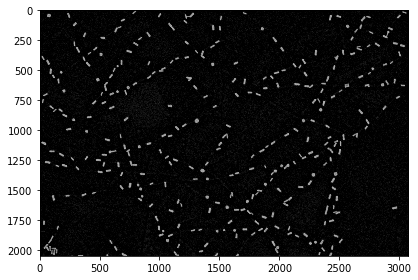

In [182]:
io.imshow(img_filtered)

In [183]:
def contour_capture(img, 
                    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)), 
                    noise_factor = 4,
                    thresh_method = cv2.THRESH_BINARY,
                    contour_thresh = 30):
    '''
    The function captures the contours from the given imgs
    Returns contours and dilated img
    '''
    #img dilation
    dilated = cv2.dilate(img, kernel)
    _, threshold = cv2.threshold(dilated, dilated.max()/4, dilated.max(), thresh_method)
    contours, _=cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [contour for contour in contours if len(contour) >= contour_thresh]
    
    return contours, dilated

In [184]:
contours, dilated = contour_capture(img_filtered)

In [185]:
def contour_summary(contours, hull = False):
    '''
    The function returns a summary based on the contour calculation
    '''
    contour_list = []
    
    for cnt in contours:
        '''
        More: add information for particle segmentation and area calculation
        output: shapetype, particle #, area of individuals
        '''
        if hull == False:
            contour_list.append(len(cnt))
        elif hull == True:
            approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True) #Tunning needed for the coeffecients
            hull = cv2.convexHull(approx)
            contour_list.append(len(hull))
    
    print(len(contour_list))
    plt.hist(contour_list)
    
    return

311


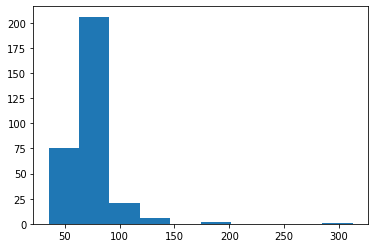

In [186]:
contour_summary(contours)

In [187]:
def shape_radar(contours, dilated, noise_factor = 4, thresh_mono = 30, thresh_di = 90, thres_poly = 130):
    '''
    Takes input from contour_capture
    return a annotated img from setted threshold
    '''
    
    #Create plot, copy the img and convert into color scale
    plt.figure(figsize=(20,16))
    dilated_c = dilated.copy()
    dilated_c = cv2.cvtColor(dilated_c,cv2.COLOR_GRAY2RGB)
    
    #Ratio between area and length of contours
    #Ratio between area and cv2.arcLength(c, True)
    #multiple predictors
    for c in contours:
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        area = cv2.contourArea(c)
        r_area_len = round((area/len(c)),1)

        #approx = cv2.approxPolyDP(c, 0.05 * cv2.arcLength(c, True), True) #Tunning needed for the coeffecients
        #hull = cv2.convexHull(approx)
        #cv2.drawContours(dilated_c, hull, -1, (100), 5)
        #print(len(hull))
        if len(c) <= thresh_di and len(c) > thresh_mono:
            if area > 1800:
                cv2.putText(dilated_c, 'dimer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255, 0, 0), 3) #Use str(len(c)) instead of text
                cv2.drawContours(dilated_c, [box], 0, (255, 0, 0), 3)
            else:
                #cv2.putText(dilated_c, str(len(c)), (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255), 5) #Use str(len(c)) instead of text
                cv2.drawContours(dilated_c, [box], 0, (255, 255, 255), 3)
        elif len(c) > thresh_di and len(c) <= thres_poly:
            cv2.putText(dilated_c, 'dimer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255, 0, 0), 3) #Use str(len(c)) instead of text
            cv2.drawContours(dilated_c, [box], 0, (255, 0, 0), 3)
        elif len(c) > thres_poly:
            #Predictor from ratio
            if r_area_len > 16.5:
                cv2.putText(dilated_c, 'polymer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(0, 255, 0), 3) #Use str(len(c)) instead of text
                cv2.drawContours(dilated_c, [box], 0, (0, 255, 0), 3)
            else:
                cv2.putText(dilated_c, 'dimer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255, 0, 0), 3) #Use str(len(c)) instead of text
                cv2.drawContours(dilated_c, [box], 0, (255, 0, 0), 3)

    return dilated_c


In [188]:
img_shape = shape_radar(contours, dilated)

<Figure size 1440x1152 with 0 Axes>

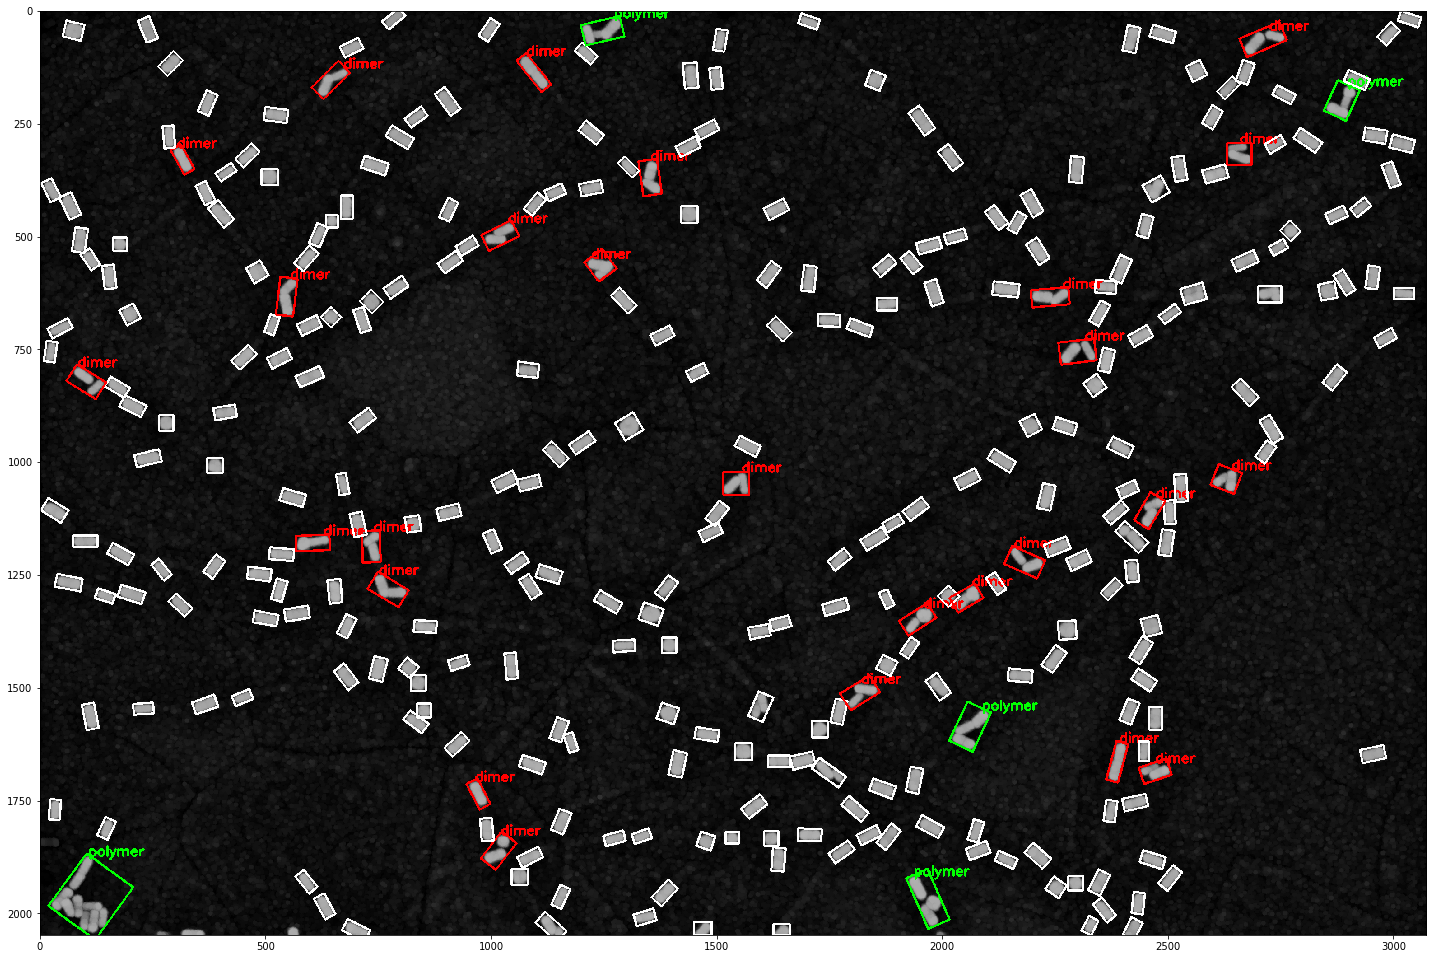

In [189]:
plt.figure(figsize=(20,16))
io.imshow(img_shape)

# Adapted from partycool_my


## Plotly_trail: https://plot.ly/python/histograms/

In [190]:
#Example of plotly

areas = [cv2.contourArea(contour) for contour in contours]
fig = go.Figure(data=[go.Histogram(x=areas)])
fig.show()

In [191]:
def area_summary(contours):
    areas = [cv2.contourArea(contour) for contour in contours]
    #output of area will be a 2D array
    
    #plotting function
    plt.figure(figsize=(8, 6))
    _ = plt.hist(areas, bins=40, color='gray')
    plt.xlabel('Area of Au NRs (pixel^2)', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    print("Total # of Au Particles :\n", len(areas))
    
    return

Total # of Au Particles :
 311


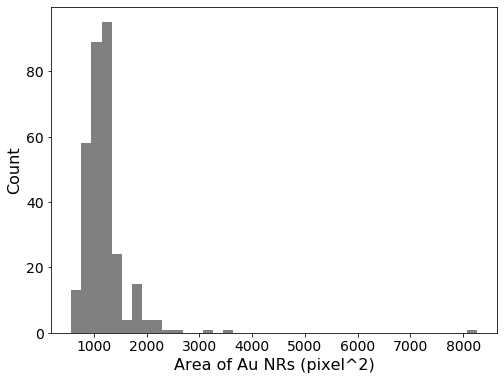

In [192]:
area_summary(contours)

In [193]:
#Information for position
def aspect_ratio(contours):
    aspectratio = []
    #Get rect area from the contours
    for i in range(0,len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i])
        aspect_ratio = float(w)/h
        aspectratio.append(aspect_ratio)

    #plotting the aspect ratio of Au NRs
    plt.figure(figsize=(8, 6))
    _ = plt.hist(aspectratio, bins=40, color='gray')
    plt.xlabel('Aspect Ratio of Au NRs', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    print("Total # of Au Particles :\n", len(aspectratio))
    
    return

Total # of Au Particles :
 311


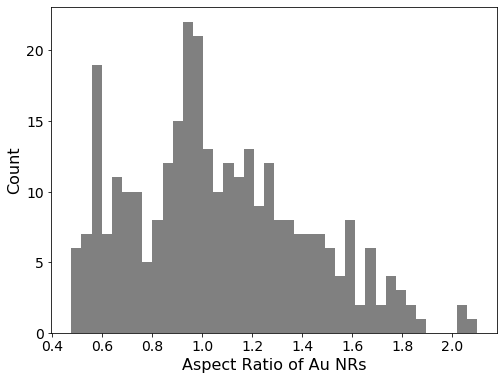

In [194]:
aspect_ratio(contours)

In [195]:
def angle_summary(contours):
    #calculating angle of Au NRs (from Maxim page)
    dictionary = OrderedDict()
    com_arr = np.empty((0, 2))
    angles = []
    for cnt in contours:
        try:
            (com), _, angle = cv2.fitEllipse(cnt)
        except:
            continue
        com = np.array(com)
        com_arr = np.append(com_arr, [com], axis=0)
        angles.append(angle)
    
    #Plotting functions
    plt.figure(figsize=(8, 6))
    _ = plt.hist(angles, bins=40, color='gray')
    plt.xlabel('Au Particles Orientation (°)', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    print("Total # of Au Particles :\n", len(angles))
    
    return

Total # of Au Particles :
 311


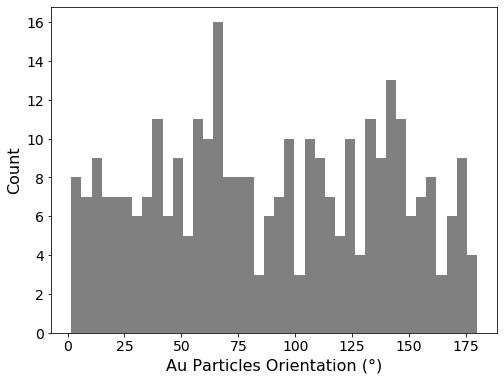

In [196]:
angle_summary(contours)

In [197]:
def particle_summary(contours, thresh_mono = 30, thresh_di = 90, thres_poly = 130):
    '''
    returns a dataframe that summarized the particle information
    '''
    
    loc_x = []
    loc_y = []
    aspect_r = []
    area_l = []
    arealen_r = []
    category_l = []
    
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        aspect_ratio = float(w)/h
        area = cv2.contourArea(c)
        r_area_len = round((area/len(c)),1)

        category = ''
        
        if len(c) <= thresh_di and len(c) > thresh_mono:
            if area > 1800:
                category = 'dimer'
            else:
                category = 'monomer'
        elif len(c) > thresh_di and len(c) <= thres_poly:
            category = 'dimer'
        elif len(c) > thres_poly:
            if r_area_len > 16.5:
                category = 'poly'
            else:
                category = 'dimer'

        loc_x.append(x)
        loc_y.append(y)
        aspect_r.append(aspect_ratio)
        area_l.append(area)
        arealen_r.append(r_area_len)
        category_l.append(category)

    result_dict = {'x' : loc_x, 
                   'y' : loc_y,
                   'aspect_ratio' : aspect_r,
                   'area' : area_l,
                   'areacontour_ratio' : arealen_r,
                   'category' : category_l}
                
    result_df = pd.DataFrame.from_dict(result_dict)
    
    return result_df


In [198]:
df = particle_summary(contours)

In [199]:
df.head()

,x,y,aspect_ratio,area,areacontour_ratio,category
0,1624,2023,1.480000,612.5,17.5,monomer
1,1448,2018,1.333333,771.0,16.1,monomer
2,675,2016,1.656250,1093.0,21.0,monomer
3,2400,2014,1.147059,864.0,16.6,monomer
4,2312,2010,0.857143,705.0,11.6,monomer
